# Libraries

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
# Defining the working directories

work_dir = '../input/cassava-leaf-disease-classification/'
os.listdir(work_dir) 
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'

2024-02-26 20:05:57.087815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 20:05:57.087901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 20:05:57.217412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading Data

In [3]:
# Importing Train Data

data = pd.read_csv(work_dir + 'train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


# Train Val Split

In [4]:
#Importing the json file with labels

f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset

data['class_name'] = data.label.map(real_labels)

# Splitting the data

from sklearn.model_selection import train_test_split

train,val = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

# Importing the data using ImageDataGenerator

IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


# Data Balancing

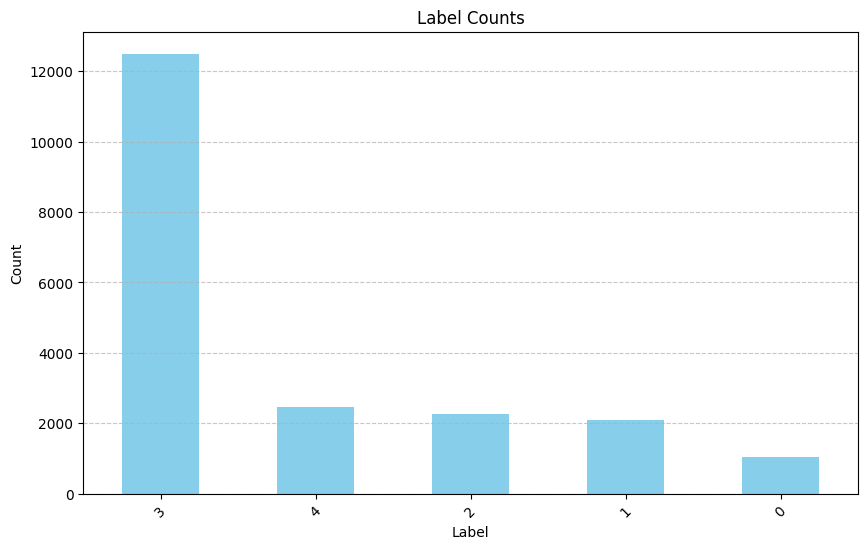

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
# Get labels from DataFrameIterator
labels = train_set.labels

# Count occurrences of each label
#label_counts = labels.value_counts()
series = pd.Series(labels)

# Now you can call value_counts() on the Series
label_counts = series.value_counts()
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
label_counts

3    12500
4     2448
2     2267
1     2079
0     1033
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Assuming train is your DataFrame with 'image_id' and 'class_name' columns
# and train_path is the path to your training images directory

# Define the parameters
IMG_SIZE = 456
size = (IMG_SIZE, IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

# Create the data generators
datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Count the number of samples for each class
class_counts = train['class_name'].value_counts()

# Determine the class with the fewest samples
min_class_samples = class_counts.min()

# Create a balanced dataset by randomly selecting an equal number of samples from each class
balanced_train = pd.DataFrame()

for class_label in class_counts.index:
    # Select a subset of the samples for the current class
    class_subset = train[train['class_name'] == class_label]
    
    # Randomly select 'min_class_samples' number of samples
    balanced_subset = class_subset.sample(n=min_class_samples, replace=False)
    
    # Ensure that balanced_subset is a DataFrame
    if not isinstance(balanced_subset, pd.DataFrame):
        balanced_subset = pd.DataFrame(balanced_subset)
    
    # Append the balanced subset to the balanced DataFrame
    balanced_train = pd.concat([balanced_train, balanced_subset], ignore_index=True)

# Shuffle the balanced DataFrame
balanced_train = balanced_train.sample(frac=1).reset_index(drop=True)

# Create a new DataFrameIterator with the balanced DataFrame
balanced_train_set = datagen_train.flow_from_dataframe(
    dataframe=balanced_train,
    directory=train_path,
    x_col='image_id',
    y_col='class_name',
    target_size=size,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Now you can use train_set for training your model

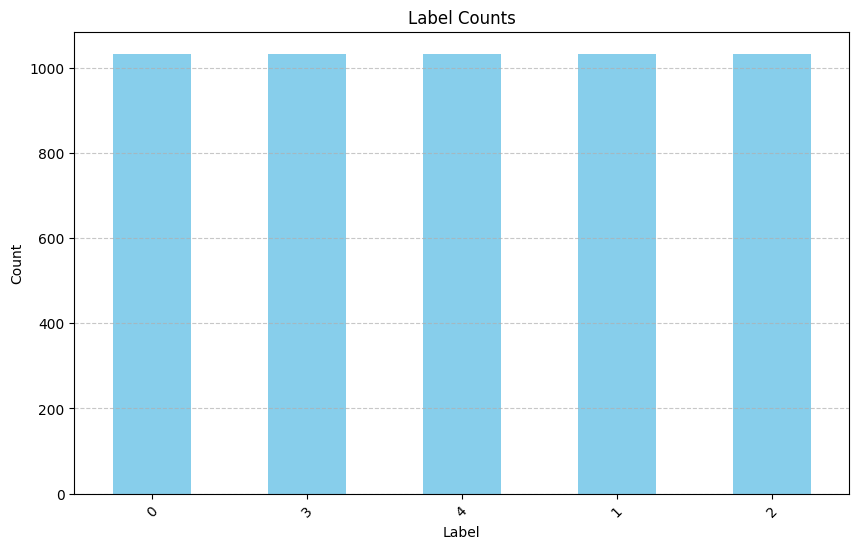

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
# Get labels from DataFrameIterator
labels = balanced_train_set.labels

# Count occurrences of each label
#label_counts = labels.value_counts()
series = pd.Series(labels)

# Now you can call value_counts() on the Series
label_counts = series.value_counts()
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Model

In [9]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

model = Sequential()
# initialize the model with input shape
model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                         weights = 'imagenet',
                         drop_connect_rate=0.6))
#for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
#    layer.trainable = False
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_CLASS, activation = 'softmax'))

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 15, 15, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

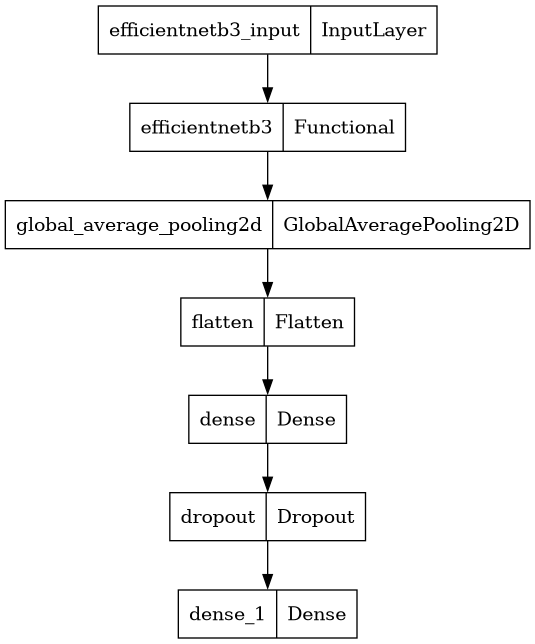

In [12]:
keras.utils.plot_model(model)

In [11]:
EPOCHS = 50
STEP_SIZE_TRAIN = balanced_train_set.n//balanced_train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [16]:
# We Create a ModelCheckpoint callback to save the best model based on validation accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
metric = 'val_categorical_accuracy'
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor=metric, save_best_only=True)

In [ ]:
#categorical_accuracy for balanced dataset
history = model.fit(balanced_train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[checkpoint])

Epoch 1/50


2024-02-21 10:03:24.297979: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708509811.495697     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


344/344 [==============================] - ETA: 0s - loss: 1.2595 - categorical_accuracy: 0.5165

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


344/344 [==============================] - 417s 1s/step - loss: 1.2595 - categorical_accuracy: 0.5165 - val_loss: 1.3747 - val_categorical_accuracy: 0.4676
Epoch 2/50
344/344 [==============================] - 308s 894ms/step - loss: 0.9423 - categorical_accuracy: 0.6561 - val_loss: 0.6275 - val_categorical_accuracy: 0.7709
Epoch 3/50
344/344 [==============================] - 320s 929ms/step - loss: 0.8494 - categorical_accuracy: 0.6953 - val_loss: 0.5532 - val_categorical_accuracy: 0.8160
Epoch 4/50
344/344 [==============================] - 303s 877ms/step - loss: 0.7954 - categorical_accuracy: 0.7231 - val_loss: 0.6470 - val_categorical_accuracy: 0.7934
Epoch 5/50
344/344 [==============================] - 305s 885ms/step - loss: 0.7674 - categorical_accuracy: 0.7282 - val_loss: 0.6086 - val_categorical_accuracy: 0.7915
Epoch 6/50
344/344 [==============================] - 309s 896ms/step - loss: 0.7471 - categorical_accuracy: 0.7293 - val_loss: 0.5579 - val_categorical_accuracy: 0

In [5]:
import keras

model = keras.models.load_model('/kaggle/input/balanced-data-model/best_model_balanced.h5')

In [6]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

72/72 [==============================] - 22s 225ms/step - loss: 0.5086 - categorical_accuracy: 0.8589


# Categorical_crossentropy

In [10]:
#categorical_accuracy
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

Epoch 1/5


2024-02-10 12:19:28.735630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707567577.007050     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1355/1355 [==============================] - 1526s 1s/step - loss: 0.7084 - categorical_accuracy: 0.7578 - val_loss: 0.5035 - val_categorical_accuracy: 0.8225
Epoch 2/5
1355/1355 [==============================] - 1362s 1s/step - loss: 0.5431 - categorical_accuracy: 0.8176 - val_loss: 0.7305 - val_categorical_accuracy: 0.7709
Epoch 3/5
1355/1355 [==============================] - 1364s 1s/step - loss: 0.5074 - categorical_accuracy: 0.8326 - val_loss: 0.5417 - val_categorical_accuracy: 0.8169
Epoch 4/5
1355/1355 [==============================] - 1362s 1s/step - loss: 0.4952 - categorical_accuracy: 0.8356 - val_loss: 0.4388 - val_categorical_accuracy: 0.8498
Epoch 5/5
1355/1355 [==============================] - 1363s 1s/step - loss: 0.4687 - categorical_accuracy: 0.8460 - val_loss: 0.4370 - val_categorical_accuracy: 0.8573


# History Plot

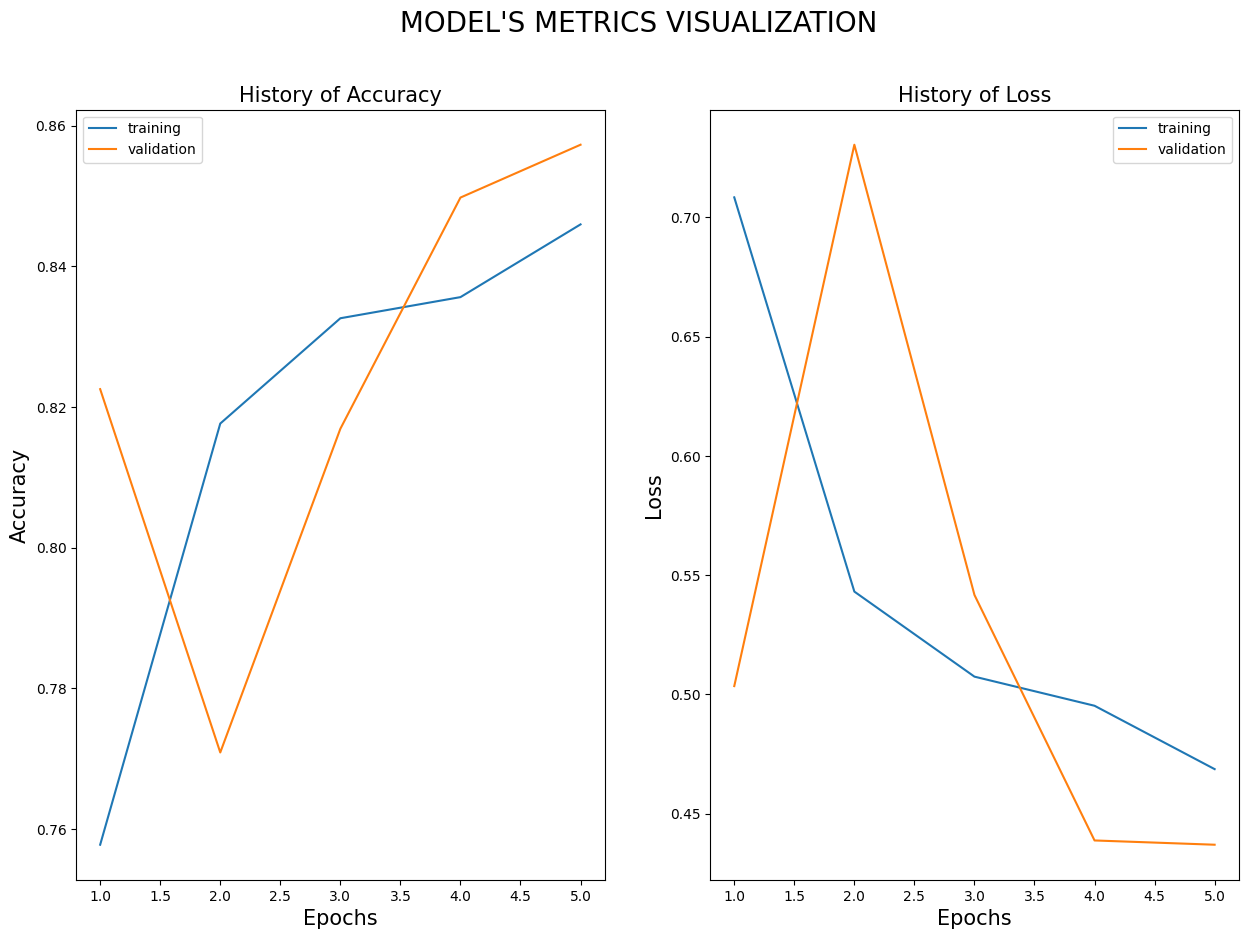

In [19]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(model.history.history['accuracy'],model.history.history['val_accuracy'],
               model.history.history['loss'],model.history.history['val_loss'])

# Taylor cross entropy loss

In [10]:
# Taylor cross entropy loss
def taylor_cross_entropy_loss(y_pred, y_true, n=3, label_smoothing=0.0):
    """Taylor Cross Entropy Loss.
    Args:
    y_pred: A multi-dimensional probability tensor with last dimension `num_classes`.
    y_true: A tensor with shape and dtype as y_pred.
    n: An order of taylor expansion.
    label_smoothing: A float in [0, 1] for label smoothing.
    Returns:
    A loss tensor.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    if label_smoothing > 0.0:
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - num_classes /(num_classes - 1) * label_smoothing) * y_true + label_smoothing / (num_classes - 1)
    
    y_pred_n_order = tf.math.maximum(tf.stack([1 - y_pred] * n), 1e-7) # avoide being too small value
    numerator = tf.math.maximum(tf.math.cumprod(y_pred_n_order, axis=0), 1e-7) # avoide being too small value
    denominator = tf.expand_dims(tf.expand_dims(tf.range(1, n+1, dtype="float32"), axis=1), axis=1)
    y_pred_taylor = tf.math.maximum(tf.math.reduce_sum(tf.math.divide(numerator, denominator), axis=0), 1e-7) # avoide being too small value
    loss_values = tf.math.reduce_sum(y_true * y_pred_taylor, axis=1, keepdims=True)
    return tf.math.reduce_sum(loss_values, -1)

class TaylorCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, n=3, label_smoothing=0.0):
        super(TaylorCrossEntropyLoss, self).__init__()
        self.n = n
        self.label_smoothing = label_smoothing
    
    def call(self, y_true, y_pred):
        return taylor_cross_entropy_loss(y_pred, y_true, n=self.n, label_smoothing=self.label_smoothing)

In [11]:
loss = TaylorCrossEntropyLoss(n=3)
    
model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [12]:
#Taylor Cross Entropy train on imbalaced dataset
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

Epoch 1/15


2024-02-10 19:00:54.047524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707591661.932057     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1355/1355 [==============================] - 1374s 962ms/step - loss: 0.7137 - categorical_accuracy: 0.7522 - val_loss: 0.7909 - val_categorical_accuracy: 0.7099
Epoch 2/15
1355/1355 [==============================] - 1141s 842ms/step - loss: 0.5425 - categorical_accuracy: 0.8185 - val_loss: 0.4965 - val_categorical_accuracy: 0.8310
Epoch 3/15
1355/1355 [==============================] - 1152s 850ms/step - loss: 0.5128 - categorical_accuracy: 0.8305 - val_loss: 0.5046 - val_categorical_accuracy: 0.8357
Epoch 4/15
1355/1355 [==============================] - 1158s 854ms/step - loss: 0.4889 - categorical_accuracy: 0.8378 - val_loss: 0.5632 - val_categorical_accuracy: 0.8160
Epoch 5/15
1355/1355 [==============================] - 1147s 846ms/step - loss: 0.4691 - categorical_accuracy: 0.8434 - val_loss: 0.4352 - val_categorical_accuracy: 0.8498
Epoch 6/15
1355/1355 [==============================] - 1130s 834ms/step - loss: 0.4523 - categorical_accuracy: 0.8525 - val_loss: 0.3821 - val_ca

# Accuracy 0.8897

In [17]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

72/72 [==============================] - 14s 155ms/step - loss: 0.3332 - categorical_accuracy: 0.8897


In [14]:
model.save('Cassava_model_taylor_model'+'.h5')  

# Testing The Model

In [16]:
import keras

model = keras.models.load_model('/kaggle/input/cassava-model/Cassava_best_model.h5')

In [9]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
datagen = ImageDataGenerator(horizontal_flip=True)


def pred(images):
    for image in test_images:
        img = Image.open(TEST_DIR + image)
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=10)
        yhats = final_model.predict_generator(it, steps=10, verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(test_images)

/tmp/ipykernel_34/3661338316.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yhats = final_model.predict_generator(it, steps=10, verbose=0)


In [10]:
# Creating the CSV for final submission

sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
#sub.to_csv('submission.csv', index = False)

,image_id,label
0,2216849948.jpg,4


#  Fliping Code

In [11]:
type(train_set)

keras.src.preprocessing.image.DataFrameIterator

In [37]:
import keras

model = keras.models.load_model('/kaggle/input/cassava-model/Cassava_best_model.h5')

# Impact flip

In [38]:
predictions = model.predict(val_set)

72/72 [==============================] - 13s 150ms/step


In [39]:
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)

In [40]:
predicted_classes

array([0, 3, 4, ..., 3, 3, 3])

In [42]:
true_labels = val_set.labels
true_labels = np.array(true_labels)

In [43]:
true_labels

array([3, 1, 3, ..., 1, 3, 3])

0.5935960888862609

In [44]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Calculate the accuracy of the model
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix to understand the type of errors
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(f'Confusion Matrix:\n{conf_matrix}')

# Flip the labels of the instances with the confidence score greater than 90%
flipped_labels = true_labels.copy()
threshold = 0.90  # Flip labels where the confidence score is greater than 90%
flipped_labels[confidences > threshold] = (true_labels[confidences > threshold] + 1) % num_classes

# Calculate the accuracy of the model with flipped labels
flipped_accuracy = accuracy_score(true_labels, flipped_labels)
print(f'Model Accuracy with Flipped Labels: {flipped_accuracy * 100:.2f}%')


Model Accuracy: 44.02%
Confusion Matrix:
[[  5   6   4  33   6]
 [  5  10  11  71  13]
 [  2  16  21  66  14]
 [ 36  54  69 416  83]
 [  6  13  14  77  19]]
Model Accuracy with Flipped Labels: 28.79%


In [37]:
def add_noise(df_orginal, noise_level):
    df = df_orginal.copy() 
    num_noisy = int(len(df) * noise_level / 100)
    indices = np.random.choice(df.index, size=num_noisy, replace=False)
    #df.loc[indices, 'label'] = np.random.randint(0, 5)  #[0.4383177570093458, 0.34392523364485983,0.4093457943925234,0.3383177570093458]
    df.loc[indices, 'label'] = -200 #[0.35046728971962615, 0.3981308411214953,0.2869158878504673,0.3728971962616822]
    return df

Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 151ms/step
Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 152ms/step
Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 155ms/step
Found 5165 validated image filenames belonging to 5 classes.
72/72 [==============================] - 11s 154ms/step


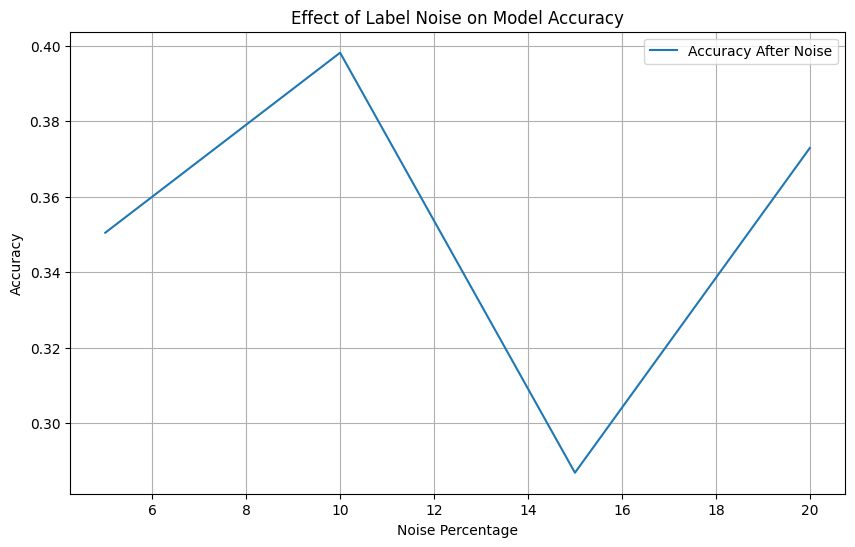

<Figure size 640x480 with 0 Axes>

In [38]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentages of noise to introduce
noise_percentages = [5, 10, 15, 20]

# Lists to store accuracy before and after noise
accuracy_before_noise = []
accuracy_after_noise = []

# Train the model and evaluate accuracy for different noise levels
for noise_percentage in noise_percentages:
    # Introduce noise to labels in the training set
    noisy_train = add_noise(balanced_train, noise_percentage)
    
    # Create new DataFrameIterators with the noisy labels
    noisy_train_set = datagen_train.flow_from_dataframe(noisy_train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)
    
    # Train the model on the noisy labels
    model.fit(noisy_train_set, epochs=3, verbose=0)  # Train for one epoch for demonstration purposes
    
    # Predict the validation set and calculate accuracy
    y_pred_noisy = model.predict(val_set)
    y_true = val_set.classes
    y_pred_classes = np.argmax(y_pred_noisy, axis=1)
    accuracy_after_noise.append(accuracy_score(y_true, y_pred_classes))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_percentages, accuracy_after_noise, label='Accuracy After Noise')
plt.xlabel('Noise Percentage')
plt.ylabel('Accuracy')
plt.title('Effect of Label Noise on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("rand_filp_Noisy.png")

In [40]:
accuracy_after_noise

[0.35046728971962615,
 0.3981308411214953,
 0.2869158878504673,
 0.3728971962616822]

# Fliping Detection

In [17]:
# Extract features from the training set
features = []
i=1
for batch in val_set:
    print(i)
    i=i+1
    if i==100:
        break
    images, labels = batch
    batch_features = images.reshape((images.shape[0], -1))  # Flatten images
    features.extend(batch_features)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [18]:
# Convert the list of features to a numpy array
X = np.array(features)

In [19]:
image_filenames=val_set.filenames[:99]
len(image_filenames)

99

In [ ]:
from sklearn.cluster import KMeans

# Save the corresponding image filenames
#image_filenames = val_set.filenames

# Number of clusters (adjust based on your data and requirements)
n_clusters = 5

# Initialize the clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels assigned to each data point
cluster_labels = kmeans.labels_

# Create a dictionary to map cluster labels to image filenames
cluster_to_images = {label: [] for label in range(n_clusters)}
for i, label in enumerate(cluster_labels):
    cluster_to_images[label].append(image_filenames[i])

# Manually inspect a sample of images from each cluster and assign labels
cluster_labels = {}
for cluster_id, images in cluster_to_images.items():
    print(f"Cluster {cluster_id}:")
    for i, image_path in enumerate(images[:5]):  # Display the first 5 images from each cluster
        print(f"{i+1}. {image_path}")
    label = input(f"Enter a label for this cluster: ")
    cluster_labels[cluster_id] = label

# Propagate the cluster labels to the entire dataset
labeled_images = []
for i, label in enumerate(cluster_labels):
    image_filename = image_filenames[i]
    cluster_id = cluster_labels[label]
    labeled_images.append((image_filename, cluster_id))

# Save the labeled images to a file
np.savetxt("labeled_images.txt", labeled_images, fmt="%s")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('Cluster Visualization with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Add cluster labels
for i, label in enumerate(cluster_labels):
    plt.annotate(str(label), (X_embedded[i, 0], X_embedded[i, 1]), fontsize=8)

# Save the plot
plt.savefig('cluster_visualization.png')
plt.show()